In [6]:
# Scientific libraries
import scipy
from scipy import stats
import numpy as np
import pandas as pd

# Graphic libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
# import japanize_matplotlib
import seaborn as sns
# import holoviews as hv
# from bokeh.io import output_notebook
# output_notebook()
# from bokeh.io import show
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# from ipywidgets import interact # Interactive graph

# Statistical libraries
# import statsmodels.stats as stats
# import statsmodels.stats.multicomp as multi
# import statsmodels.formula.api as smf
# import scikit_posthocs as sp

# Other libraries
# import re
# from datetime import datetime
# import collections

# Creating alias for magic commands
%alias_magic t time

from icecream import ic

import requests
import zipfile
import math
from scipy.stats import poisson

Created `%t` as an alias for `%time`.
Created `%%t` as an alias for `%%time`.


In [5]:
# 著者サイトからdata3a.csvをダウンロード
response = requests.get('https://kuboweb.github.io/-kubo/stat/iwanamibook/fig/poisson/data3a.csv')
with open ('data3a.csv', 'wb') as f:
    f.write(response.content)
    f.close()
data = pd.read_csv('data3a.csv')
data

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C
...,...,...,...
95,8,9.15,T
96,6,8.52,T
97,8,10.24,T
98,7,10.86,T


$$
\begin{align}
  x &\stackrel{\text{def}}{=} \text{体サイズ} \\
  y &\stackrel{\text{def}}{=} \text{種子数} \\
  f &\stackrel{\text{def}}{=} \text{施肥の有無} \\
\end{align}
$$

In [40]:
display(data.describe(include="all"))
display(data.value_counts("f"))

print("variance:")
display(data.var())

print("standard error:")
display(data.sem())

,y,x,f
count,100.000000,100.000000,100
unique,NaN,NaN,2
top,NaN,NaN,C
freq,NaN,NaN,50
mean,7.830000,10.089100,NaN
std,2.624881,1.008049,NaN
min,2.000000,7.190000,NaN
25%,6.000000,9.427500,NaN
50%,8.000000,10.155000,NaN
75%,10.000000,10.685000,NaN


f
T    50
C    50
dtype: int64

variance:


y    6.890000
x    1.016162
dtype: float64

standard error:


y    0.262488
x    0.100805
dtype: float64

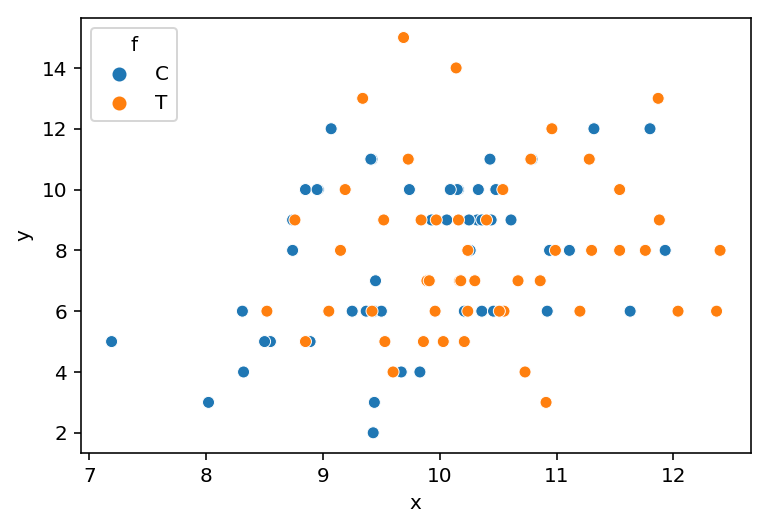

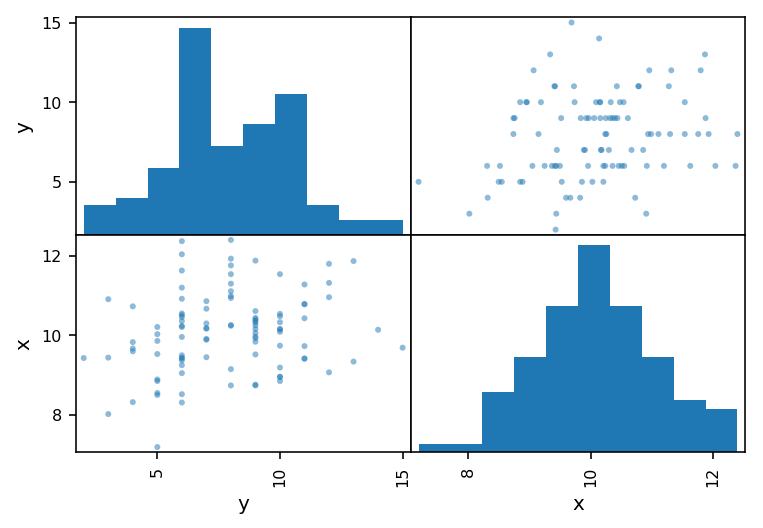

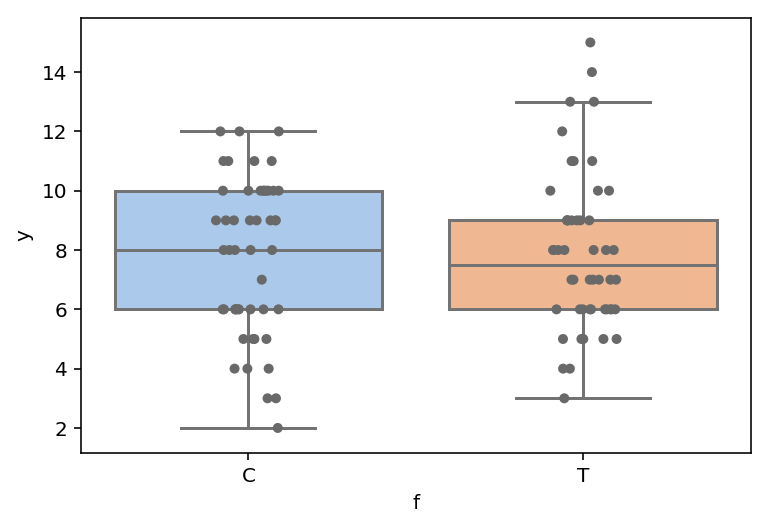

In [57]:
sns.scatterplot(data=data,
                x="x",
                y="y",
                hue="f")
plt.show()

pd.plotting.scatter_matrix(data,
                           diagonal='hist')

plt.show()

sns.boxplot(data=data,
            x="f",
            y="y",
            fliersize=0,
            palette="pastel")
sns.stripplot(data=data,
              x="f",
              y="y",
              color="dimgrey",)
plt.show()

# Poisson distribution

- 前回は，平均種子数$\lambda$が全固体で共通であると仮定した
- 今回は，個体ごとの平均種子数$\lambda_i$が体サイズ$x$や施肥処理$f$に影響されるモデルを想定

$$
\begin{align}
  P(y_i | \lambda_i) &= \frac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i !} \\
  x_i &\stackrel{\text{def}}{=} 個体iの体サイズ, 説明変数 \\
  y_i &\stackrel{\text{def}}{=} 個体iの種子数, 応答変数 \\
\end{align}
$$

ある個体$i$の平均種子数$\lambda_i$が

$$
\lambda_i = \exp(\beta_1 + \beta_2 x_i)
$$

であるとする．

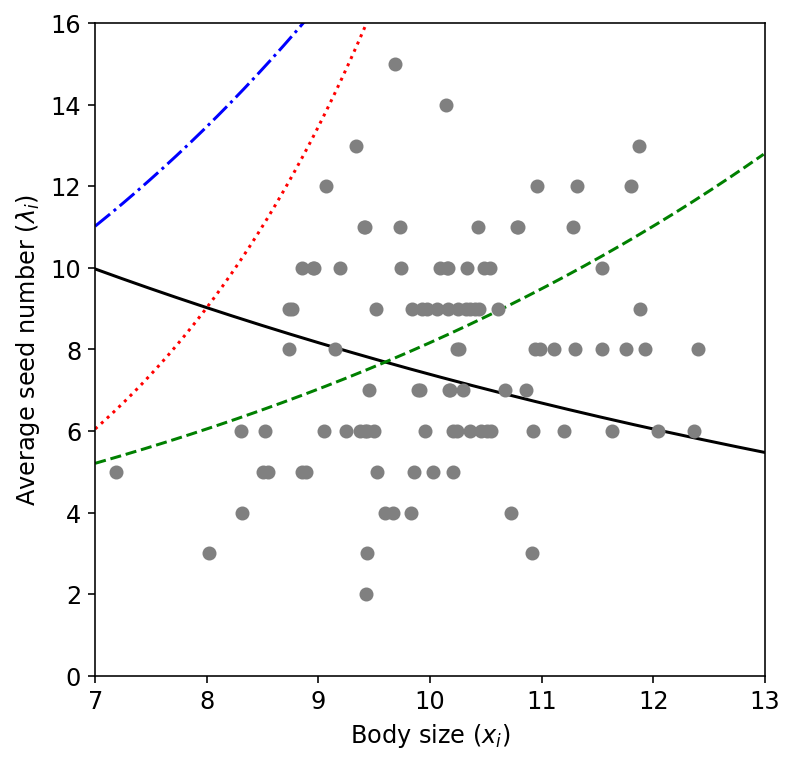

In [123]:
def body_seed_func(x, b1, b2):
    return np.exp(b1 + b2*x)

# Set parameters
rcParams['font.size'] = 12
rcParams['figure.figsize'] = (6, 6)

xlim = (math.floor(data["x"].min()),
        math.ceil(data["x"].max()))
ylim = (0,
        math.ceil(data["y"].max()))

# Generate Figure & Axes instances
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = np.arange(xlim[0], xlim[1], 0.01)
y_1 = body_seed_func(x, 3, -0.1)
y_2 = body_seed_func(x, -1, 0.4)
y_3 = body_seed_func(x, 1, 0.2)
y_4 = body_seed_func(x, 0.6, 0.15)

ax.plot(x, y_1, 'k-')
ax.plot(x, y_2, 'r:')
ax.plot(x, y_3, 'b-.')
ax.plot(x, y_4, 'g--')

ax.plot(data["x"],
        data["y"],
        'o',
        color='grey')

# X-axis Settings
ax.set_xlim(xlim[0], xlim[1])
ax.set_xlabel('Body size ($x_i$)')

# Y-axis Settings
ax.set_ylim(ylim[0], ylim[1] + 1)
ax.set_ylabel('Average seed number ($\lambda_i$)')

plt.show()

# Link function

$$
\lambda_i = \exp(\beta_1 + \beta_2 x_i) \\
\Leftrightarrow \log{\lambda_i} = \beta_1 + \beta_2 x_i
$$

- 右辺のように，$\{\beta_1, \beta_2, ...\}$の線形結合で表現できる関数を**線形予測子**と呼ぶ
- 線形予測子で表す子ができる関数を**リンク関数**と呼ぶ
- リンク関数が対数関数の場合は，対数リンク関数(log link function)と呼ばれる

# Log likelihood of the model

$$
\begin{align}
  \log{L(\beta_1, \beta_2)} &= \log{\left( \prod_{i}{\frac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i !}} \right)} \\
  &= \sum_{i}{\log{\frac{\lambda_i^{y_i} e^{-\lambda_i}}{y_i !}}}
\end{align}
$$

In [167]:
# in R;
# $ fit <- glm(y ~ x, data=d, family=poisson)
# $ print(fit)

import statsmodels.formula.api as smf

fitted = smf.poisson('y ~ x',
                  data=data).fit()

display(fitted.summary2())


# https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

b_1 = fitted.params["Intercept"]
b_2 = fitted.params["x"]

print("Log-likelihood: {}".format(fitted.llf))
print("AIC: {}".format(fitted.aic))
print("BIC: {}".format(fitted.bic))

Optimization terminated successfully.
         Current function value: 2.353863
         Iterations 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Poisson
===============================================================
Model:              Poisson          Pseudo R-squared: 0.009   
Dependent Variable: y                AIC:              474.7725
Date:               2021-01-22 22:43 BIC:              479.9828
No. Observations:   100              Log-Likelihood:   -235.39 
Df Model:           1                LL-Null:          -237.64 
Df Residuals:       98               LLR p-value:      0.033620
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     4.0000                                     
-----------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Intercept   1.2917     0.3637   3.5517   0.0004   0.5789   2.0045
x           0.0757     0.0356   2.1251   0.0336   0.0059   0.1454
===============================================================

"""

Log-likelihood: -235.38625076986077
AIC: 474.77250153972153
BIC: 479.98284191169773


array([6.82417428, 7.43329559, 7.46711734, 7.22808696, 7.84946903,
       6.82933953, 8.12132852, 7.79030256, 7.71405238, 8.01147274,
       7.96915348, 7.84353222, 8.31406738, 7.1087668 , 7.42205575,
       8.43445169, 6.67606935, 8.97432281, 6.94922545, 6.26970939,
       7.65590663, 8.23269068, 7.1303139 , 7.80800552, 8.77291299,
       7.87922057, 7.43892189, 8.01753667, 7.43329559, 8.04183831,
       7.42767354, 7.94507148, 7.95108515, 6.92298553, 7.4164422 ,
       7.16817861, 7.56378368, 7.90908487, 7.96915348, 8.88648364,
       8.32665807, 7.90310296, 7.0498474 , 8.0296783 , 7.39403044,
       7.60395028, 7.16275708, 7.0498474 , 8.56953705, 7.32720071,
       7.8375999 , 7.21715741, 7.69074127, 7.06052358, 9.04932609,
       7.70238801, 7.66170143, 8.93367428, 7.84946903, 7.37726608,
       7.85541034, 8.35821828, 7.2940127 , 8.15828085, 8.33926783,
       8.08454357, 7.57523816, 8.30777918, 7.52382926, 9.27811797,
       8.07842896, 8.5565791 , 9.2992019 , 7.86135614, 7.48408

# Parameters

## `std err`

最尤推定地のばらつきぐあい

## `z`

- 統計量`z`, Wald統計量とも呼ばれる
- 最尤推定地をstandard errorで割った値
- "Wald信頼区間"を構成できる
- 推定値がゼロから十分に離れているかの洗い目安となる

## `Pr(>|z|)`

- ポアソン分布の場合，平均 $z$, 標準偏差 $1$の正規分布における、$(- \infty, 0)$の範囲に入る確率の2倍(両側検定)
    - たとえば正規分布だったら，$t$分布を使って確率を計算する
- この確率が大きいほど，`z`がゼロに近くなる
- 推定値$\hat{\beta_1}$や$\hat{\beta_2}$がゼロに近いことを表現する方法のひとつ
- 推定値の信頼区間が近似的に算出されたと考えて解釈すべき

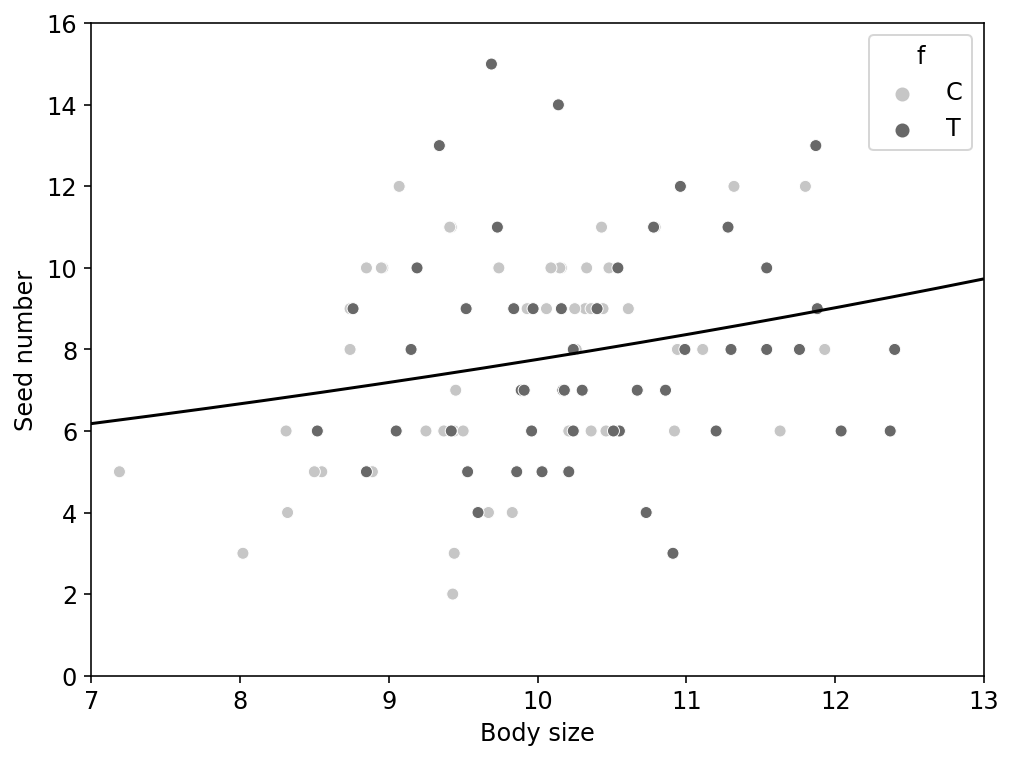

In [135]:
# Set parameters
rcParams['font.size'] = 12
rcParams['figure.figsize'] = (8, 6)

xlim = (math.floor(data["x"].min()),
        math.ceil(data["x"].max()))
ylim = (0,
        math.ceil(data["y"].max()))

# Generate Figure & Axes instances
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

x = np.arange(xlim[0], xlim[1], 0.01)
y = body_seed_func(x, b_1, b_2)

ax.plot(x,
        y,
        'k-')

sns.scatterplot(data=data,
                x="x",
                y="y",
                hue="f",
                palette="Greys",
               )
# ax.plot(data["x"],
#         data["y"],
#         'o',
#         color='grey')

# X-axis Settings
ax.set_xlim(xlim[0], xlim[1])
ax.set_xlabel('Body size')

# Y-axis Settings
ax.set_ylim(ylim[0], ylim[1] + 1)
ax.set_ylabel('Seed number')

# Legend Settings
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# save_fig(filename)
plt.show()